In [1]:
import os
import pandas as pd
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
import tqdm
import clip
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score
import umap
from sklearn.metrics import f1_score

/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be 

In [2]:
df = pd.read_csv("Kather_train.csv", index_col=0)

In [3]:
set(df['caption'])

{'An H&E image patch of adipose tissue.',
 'An H&E image patch of background.',
 'An H&E image patch of cancer-associated stroma.',
 'An H&E image patch of colorectal adenocarcinoma epithelium.',
 'An H&E image patch of debris.',
 'An H&E image patch of lymphocytes.',
 'An H&E image patch of mucus.',
 'An H&E image patch of normal colon mucosa.',
 'An H&E image patch of smooth muscle.'}

In [4]:
set(df['label'])

{'ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'}

In [5]:
root_folder = "NCT-CRC-HE-100K" 

for sub_folder in os.listdir(root_folder):
    sub_folder_path = os.path.join(root_folder, sub_folder)
    
    if os.path.isdir(sub_folder_path):  
        # Count the number of '.tif' images in the sub-folder
        num_images = len([f for f in os.listdir(sub_folder_path) if os.path.isfile(os.path.join(sub_folder_path, f)) and f.endswith(".tif")])
        
        print(f"{sub_folder}: {num_images} images")

ADI: 10407 images
BACK: 10566 images
DEB: 11512 images
LYM: 11557 images
MUC: 8896 images
MUS: 13536 images
NORM: 8763 images
STR: 10446 images
TUM: 14317 images


In [6]:
texts = ["An H&E image patch of adipose tissue." for _ in range(10407)]
texts.extend(["An H&E image patch of background." for _ in range(10566)])
texts.extend(["An H&E image patch of cancer-associated stroma." for _ in range(11512)])
texts.extend(["An H&E image patch of colorectal adenocarcinoma epithelium." for _ in range(11557)])
texts.extend(["An H&E image patch of debris." for _ in range(8896)])
texts.extend(["An H&E image patch of lymphocytes." for _ in range(13536)])
texts.extend(["An H&E image patch of mucus." for _ in range(8763)])
texts.extend(["An H&E image patch of normal colon mucosa." for _ in range(10446)])
texts.extend(["An H&E image patch of smooth muscle." for _ in range(14317)])

In [7]:
print(texts[90000:90010])
print(len(texts))

['An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of smooth muscle.']
100000


In [8]:
root_dir = "NCT-CRC-HE-100K"
subfolders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

tif_files = []

# Sort subfolders to ensure consistent order
for subfolder in sorted(subfolders):
    subfolder_path = os.path.join(root_dir, subfolder)
    
    # Fetch and sort filenames in the current subfolder
    for filename in sorted([f for f in os.listdir(subfolder_path) if f.endswith('.tif')]):
        tif_files.append(os.path.join(subfolder_path, filename))

# Use Image.open() to load images and store them as PIL Images in a list
image_list = []
for tif_file in tif_files:
    with Image.open(tif_file).convert('RGB') as img:
        image_list.append(img.copy())

# Print the number of loaded images
print(f"Loaded {len(image_list)} images.")

Loaded 100000 images.


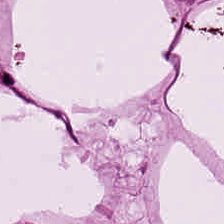

In [9]:
image_list[0]

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training

In [12]:
processed_images = []
for img in image_list:
    processed_img = preprocess(img)
    processed_images.append(processed_img)

In [13]:
len(processed_images)

100000

In [14]:
dataloader_images = DataLoader(processed_images, batch_size=100, shuffle=False)

In [15]:
image_embeddings_initial = []
                      
total = len(processed_images) // 100
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for images in dataloader_images:
        images = images.to(device)
        image_embeddings_initial.extend(model.encode_image(images).detach().cpu().numpy())
        pbar.update(1)
    pbar.close()
image_embeddings_initial = np.array(image_embeddings_initial)
print(image_embeddings_initial.shape)

100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


(100000, 512)


In [16]:
dataloader_texts = DataLoader(texts, batch_size = 100, shuffle=False)

In [17]:
text_embeddings_initial = []
total = len(texts) // 100

pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for captions in dataloader_texts:
        idx = clip.tokenize(captions, truncate=True).to(device)
        text_embeddings_initial.extend(model.encode_text(idx).detach().cpu().numpy())

        pbar.update(1)

    pbar.close()

text_embeddings_initial = np.array(text_embeddings_initial)
print(text_embeddings_initial.shape)

100%|██████████| 1000/1000 [00:42<00:00, 23.68it/s]


(100000, 512)


In [18]:
image_embeddings_initial_norm = image_embeddings_initial / np.linalg.norm(image_embeddings_initial, axis=1, keepdims=True)
text_embeddings_initial_norm = text_embeddings_initial / np.linalg.norm(text_embeddings_initial, axis=1, keepdims=True)
print(image_embeddings_initial_norm.shape)
print(text_embeddings_initial_norm.shape)

(100000, 512)
(100000, 512)


In [19]:
reducer = umap.UMAP(n_components=3, random_state=0)
embeddings_images = reducer.fit_transform(image_embeddings_initial_norm)
embeddings_texts = reducer.fit_transform(text_embeddings_initial_norm)
print(embeddings_texts.shape)
print(embeddings_images.shape)

(100000, 3)
(100000, 3)


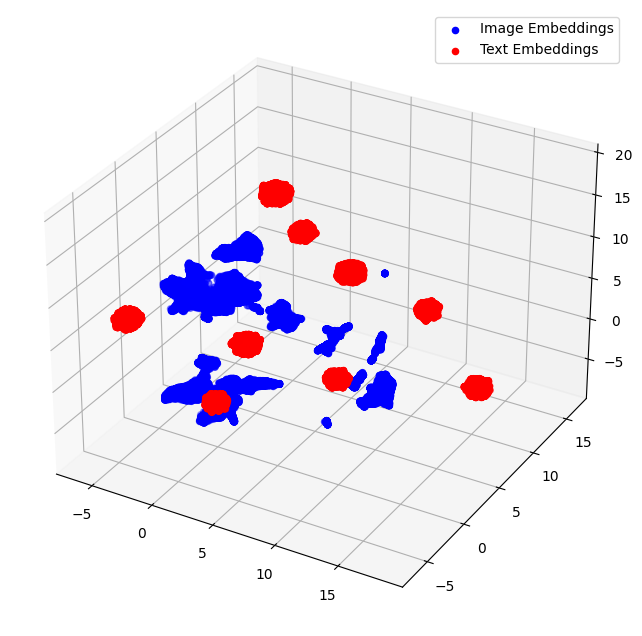

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_images[:, 0], embeddings_images[:, 1], embeddings_images[:, 2], color='b', label='Image Embeddings')
ax.scatter(embeddings_texts[:, 0], embeddings_texts[:, 1], embeddings_texts[:, 2], color='r', label='Text Embeddings')
ax.legend()
plt.show()

In [275]:
class ContrastiveDataset(Dataset):
    def __init__(self, image_embeddings, text_embeddings):
        self.image_embeddings = image_embeddings
        self.text_embeddings = text_embeddings
        assert len(self.image_embeddings) == len(self.text_embeddings), "Mismatched embeddings lengths!"

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        return self.image_embeddings[idx], self.text_embeddings[idx]

In [276]:
batch_size = 100
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training

In [277]:
train_dataset = ContrastiveDataset(processed_images, texts)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
num_batches_per_epoch = len(train_dataloader)
print(num_batches_per_epoch)
total_steps = len(train_dataloader) * epochs
print(total_steps)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay = 0.0001)

1000
20000


In [278]:
train_dataset[0]

(tensor([[[ 0.9084,  0.8647,  0.9960,  ...,  1.4486,  1.4486,  1.4632],
          [ 1.0252,  0.8647,  0.9668,  ...,  1.3026,  1.4340,  1.4194],
          [ 1.2150,  0.9668,  0.9814,  ...,  1.4632,  1.5216,  1.5654],
          ...,
          [ 1.6384,  1.6384,  1.6384,  ...,  1.6384,  1.6384,  1.6092],
          [ 1.6384,  1.6384,  1.6384,  ...,  1.6384,  1.6384,  1.6092],
          [ 1.6384,  1.6384,  1.6384,  ...,  1.6384,  1.6384,  1.6092]],
 
         [[ 0.1089, -0.0112,  0.0488,  ...,  1.0243,  1.1294,  1.1744],
          [ 0.2289,  0.0939,  0.1689,  ...,  0.9793,  1.1744,  1.2495],
          [ 0.4841,  0.3190,  0.2740,  ...,  1.1894,  1.3395,  1.3845],
          ...,
          [ 1.5946,  1.5646,  1.5496,  ...,  1.5946,  1.5946,  1.5946],
          [ 1.5946,  1.5646,  1.5496,  ...,  1.5946,  1.5946,  1.5946],
          [ 1.5946,  1.5646,  1.5496,  ...,  1.5946,  1.5946,  1.5946]],
 
         [[ 0.9799,  0.8945,  0.9656,  ...,  1.5913,  1.6624,  1.6766],
          [ 1.0510,  0.9941,

In [279]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [280]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [281]:
def assign_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = new_lr


def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length


def cosine_lr(optimizer, base_lr, warmup_length, steps):
    def _lr_adjuster(step):
        if step < warmup_length:
            lr = _warmup_lr(base_lr, warmup_length, step)
        else:
            e = step - warmup_length
            es = steps - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        assign_learning_rate(optimizer, lr)
        return lr
    return _lr_adjuster

# lr_scheduler = cosine_lr(optimizer, base_lr=0.01, warmup_length=5, steps=100)
# current_lr = lr_scheduler(3)  # This is effectively calling _lr_adjuster(3)

In [282]:
scheduler = cosine_lr(optimizer, 5e-5, 300, total_steps)

In [283]:
current_directory = os.getcwd() 
checkpoint_dir = os.path.join(current_directory, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [287]:
# loading the checkpoint 
checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime) if checkpoint_files else None
# returns the last modification time of that file

if latest_checkpoint:  # check if latest_checkpoint is not None
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    if os.path.exists(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        training_losses = checkpoint['training_losses']
else:
    start_epoch = 0 
    training_losses = []

In [288]:
# training_losses = []

epochs = 20

for epoch in range(start_epoch, epochs):
    train_loss_this_epoch = 0
    
    for i, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"{epoch}/{epochs}", position=0)):
        optimizer.zero_grad()
        
        step = num_batches_per_epoch * epoch + i
        scheduler(step)
        
        images_batch, texts_batch = batch
        images_batch = images_batch.to(device)
        texts_new = clip.tokenize(texts_batch, truncate=True).to(device)
        
        images_embeddings = model.encode_image(images_batch)
        texts_embeddings = model.encode_text(texts_new)
        
        images_embeddings_norm = images_embeddings / images_embeddings.norm(dim=1, keepdim=True)
        texts_embeddings_norm = texts_embeddings / texts_embeddings.norm(dim=1, keepdim=True)
        
        
        logit_scale = model.logit_scale.exp()
        # print(logit_scale) # tensor(100., device='cuda:0', grad_fn=<ExpBackward>)
        
        logits_per_image = logit_scale * images_embeddings_norm @ texts_embeddings_norm.t() # cosine similarity
        # (batch_size, embedding_dim) @ (embedding_dim, batch_size) = (batch_size, batch_size)
        # each row corresponds to an image
        logits_per_text = logits_per_image.t()
        # each row corresponds to a text
        
        # logits_per_image, logits_per_text = model(images_batch, texts_new)

        ground_truth = torch.arange(len(images_batch), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().numpy() 
        # using .item() is more memory efficient for scalars comparing to .numpy()
        
        # new_lr = scheduler(step)
        # print(f'[Train - this batch] epoch: {epoch}, batch: {i}, new learning rate: {new_lr}')
        
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses.append(train_loss_this_epoch)
    
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        'training_losses': training_losses
    }, checkpoint_path)
    
    # Deleting previous checkpoints
    if epoch > 0:
        previous_checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch - 1}.pth")
        if os.path.exists(previous_checkpoint_path):
            os.remove(previous_checkpoint_path)

In [291]:
image_embeddings_trained = []
                      
total = len(processed_images) // 100
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for images in dataloader_images:
        images = images.to(device)
        image_embeddings_trained.extend(model.encode_image(images).detach().cpu().numpy())
        pbar.update(1)
    pbar.close()
image_embeddings_trained = np.array(image_embeddings_trained)
print(image_embeddings_trained.shape)

100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]


(100000, 512)


In [292]:
text_embeddings_trained = []

total = len(texts) // 100
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for captions in dataloader_texts:
        idx = clip.tokenize(captions, truncate=True).to(device)
        text_embeddings_trained.extend(model.encode_text(idx).detach().cpu().numpy())

        pbar.update(1)

    pbar.close()

text_embeddings_trained = np.array(text_embeddings_trained)
print(text_embeddings_trained.shape)

100%|██████████| 1000/1000 [00:42<00:00, 23.62it/s]


(100000, 512)


In [293]:
image_embeddings_trained_norm = image_embeddings_trained / np.linalg.norm(image_embeddings_trained, axis=1, keepdims=True)
text_embeddings_trained_norm = text_embeddings_trained / np.linalg.norm(text_embeddings_trained, axis=1, keepdims=True)
print(image_embeddings_trained_norm.shape)
print(text_embeddings_trained_norm.shape)

(100000, 512)
(100000, 512)


In [294]:
reducer = umap.UMAP(n_components=3, random_state=0)
embeddings_images_trained = reducer.fit_transform(image_embeddings_trained_norm)
embeddings_texts_trained = reducer.fit_transform(text_embeddings_trained_norm)

In [295]:
unique_texts = set(df['caption'])

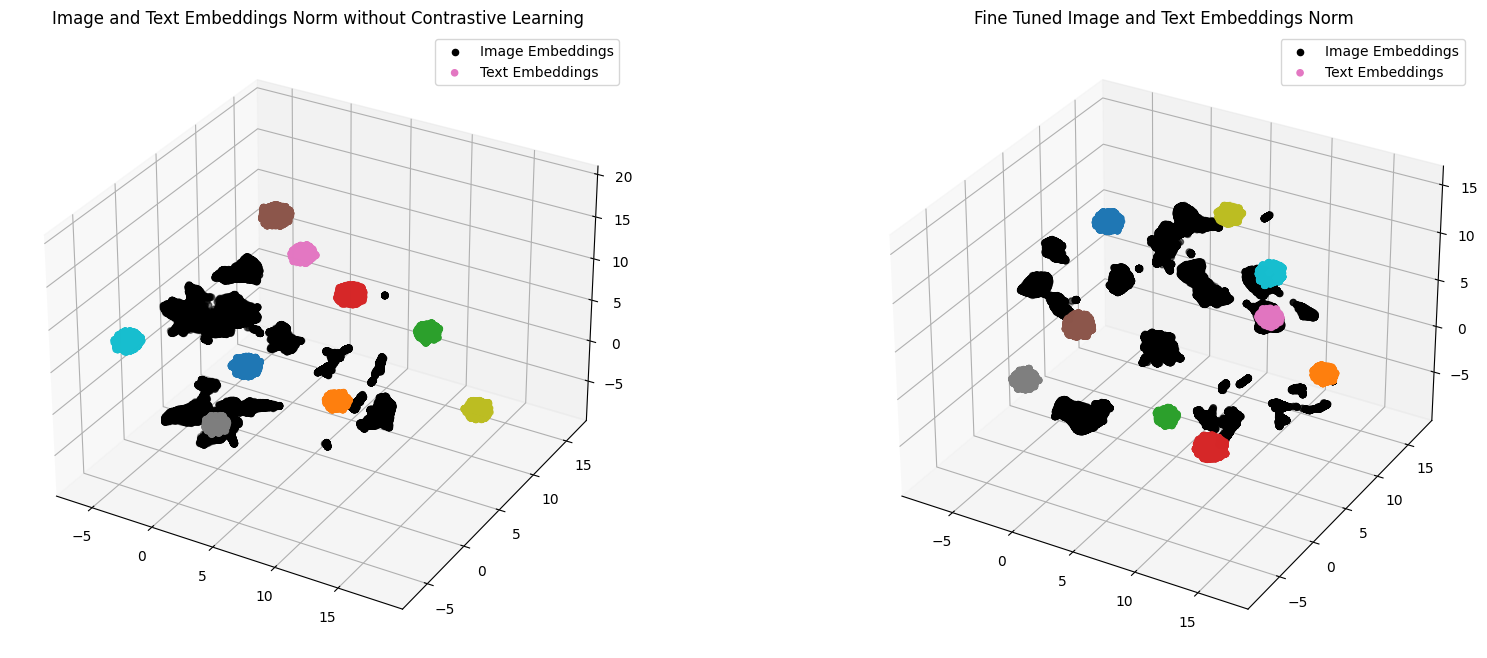

In [296]:
cmap = plt.get_cmap('tab10', len(unique_texts))

fig = plt.figure(figsize=(20, 8))  
label_dict = {t: i for i, t in enumerate(unique_texts)}
colors = []
for captions in dataloader_texts:
    colors += [cmap(label_dict[caption]) for caption in captions]

# First plot
ax1 = fig.add_subplot(121, projection='3d')  
ax1.scatter(embeddings_images[:, 0], embeddings_images[:, 1], embeddings_images[:, 2], color="black", label='Image Embeddings')
ax1.scatter(embeddings_texts[:, 0], embeddings_texts[:, 1], embeddings_texts[:, 2], color=colors, label='Text Embeddings')
ax1.legend()
ax1.set_title('Image and Text Embeddings Norm without Contrastive Learning')

# Second plot
ax2 = fig.add_subplot(122, projection='3d') 
ax2.scatter(embeddings_images_trained[:, 0], embeddings_images_trained[:, 1], embeddings_images_trained[:, 2], color="black", label='Image Embeddings')
ax2.scatter(embeddings_texts_trained[:, 0], embeddings_texts_trained[:, 1], embeddings_texts_trained[:, 2], color=colors, label='Text Embeddings')
ax2.legend()
ax2.set_title('Fine Tuned Image and Text Embeddings Norm')

plt.show()

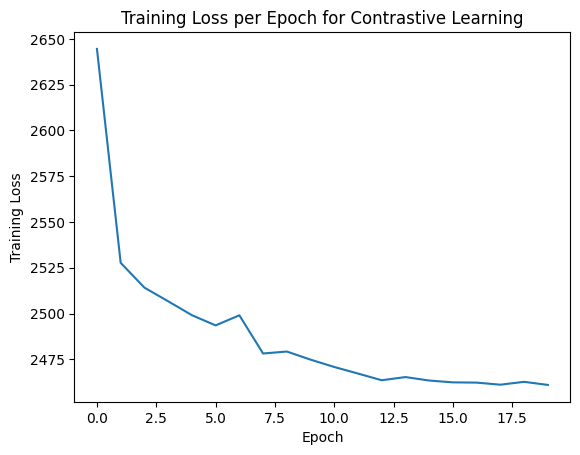

In [297]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Contrastive Learning')
plt.show()

In [298]:
# Test Set

In [299]:
df2 = pd.read_csv("Kather_test.csv", index_col=0)

In [300]:
image_filenames = []
for dirpath, _, filenames in os.walk("CRC-VAL-HE-7K"):
    for filename in (f for f in filenames if f.endswith('.tif')):
        # base_name = filename.split('.')[0]
        image_filenames.append(filename)
print(len(image_filenames))

7180


In [301]:
matched_df = df2.set_index('filename').reindex(image_filenames).reset_index()
texts2 = matched_df['caption']
print(len(texts2))

7180


In [302]:
tif_files2 = []
for dirpath, _, filenames in os.walk("CRC-VAL-HE-7K"):
    for filename in [f for f in filenames if f.endswith('.tif')]:
        tif_files2.append(os.path.join(dirpath, filename))

# Use Image.open() to load images and store them as PIL Images in a list
image_list2 = []
for tif_file in tif_files2:
    with Image.open(tif_file).convert('RGB') as img:
        image_list2.append(img.copy())

# Print the number of loaded images
print(f"Loaded {len(image_list2)} images.")

Loaded 7180 images.


In [303]:
processed_images2 = []
for img in image_list2:
    processed_img = preprocess(img)
    processed_images2.append(processed_img)
print(len(processed_images2))

7180


In [304]:
# End Test Set 

In [305]:
def calculate_f1_score(self, outputs, labels, average='weighted'):
    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted_labels = np.argmax(outputs, axis=1)
    # axis = 1 returns the index of the maximum value along each row
    f1 = f1_score(labels, predicted_labels, average=average)
    return f1

In [306]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        # input: (batch_size, input_size)
        # output: (batch_Size, num_classes)
        
    def forward(self, x):
        x = x.to(self.fc.weight.dtype)
        # ensuring that the input x has the same data type
        out = self.fc(x)
        return out

In [307]:
input_size = 512
num_classes = len(unique_texts)
linear_classifier = LinearClassifier(input_size, num_classes)
linear_classifier = linear_classifier.to(device)

In [308]:
descriptions = {
    'An H&E image patch of cancer-associated stroma.', 
    'An H&E image patch of lymphocytes.', 
    'An H&E image patch of mucus.', 
    'An H&E image patch of smooth muscle.', 
    'An H&E image patch of background.', 
    'An H&E image patch of normal colon mucosa.', 
    'An H&E image patch of debris.', 
    'An H&E image patch of colorectal adenocarcinoma epithelium.', 
    'An H&E image patch of adipose tissue.'
}

labels = [' '.join(desc.split()[5:]).rstrip('.') for desc in descriptions]

print(labels)
print(labels[3])

['cancer-associated stroma', 'mucus', 'debris', 'smooth muscle', 'lymphocytes', 'adipose tissue', 'normal colon mucosa', 'background', 'colorectal adenocarcinoma epithelium']
smooth muscle


In [309]:
label_to_int = {label: idx for idx, label in enumerate(labels)}
int_labels = [label_to_int[label] for label in labels]
print(int_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [310]:
texts_labels = [' '.join(desc.split()[5:]).rstrip('.') for desc in texts]
print(len(texts_labels))
print(texts_labels[0:10])

100000
['adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue']


In [311]:
texts_labels_int = [label_to_int[label] for label in texts_labels]
texts_labels_int = np.array(texts_labels_int)
print(len(texts_labels_int))
print(texts_labels_int[0:10])

100000
[5 5 5 5 5 5 5 5 5 5]


In [312]:
class LinearClassifierDataset(Dataset):
    def __init__(self, image_embeddings, labels):
        self.image_embeddings = image_embeddings
        self.labels = labels
        assert len(self.image_embeddings) == len(self.labels), "Mismatched Lengths!"

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        return self.image_embeddings[idx], self.labels[idx]

In [313]:
epochs = 30
batch_size = 100
train_dataset_linear_classifier = LinearClassifierDataset(image_embeddings_initial, texts_labels_int)
train_dataloader_linear_classifier = DataLoader(train_dataset_linear_classifier, batch_size = batch_size, shuffle = True)
num_batches_per_epoch = len(train_dataloader_linear_classifier)
print(num_batches_per_epoch)
total_steps = len(train_dataloader_linear_classifier) * epochs
print(total_steps)
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001)

1000
30000


In [314]:
training_losses_linear_classifier = []
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss_this_epoch = 0
    for i, batch in enumerate(tqdm.tqdm(train_dataloader_linear_classifier, desc=f"{epoch}/{epochs}", position=0)):
        optimizer.zero_grad()

        images_embeddings, labels = batch
        images_embeddings = images_embeddings.to(device)
        labels = labels.to(device)
        
        outputs = linear_classifier(images_embeddings)
        total_loss = criterion(outputs, labels)  
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().item()  
        
        optimizer.step()
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses_linear_classifier.append(train_loss_this_epoch)

0/30: 100%|██████████| 1000/1000 [00:01<00:00, 550.42it/s]


train_loss_this_epoch is: 1380.9139196276665


1/30: 100%|██████████| 1000/1000 [00:01<00:00, 553.60it/s]


train_loss_this_epoch is: 794.5935995578766


2/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.87it/s]


train_loss_this_epoch is: 595.1386281549931


3/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.30it/s]


train_loss_this_epoch is: 489.07670614123344


4/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.07it/s]


train_loss_this_epoch is: 421.9143507182598


5/30: 100%|██████████| 1000/1000 [00:01<00:00, 563.82it/s]


train_loss_this_epoch is: 375.507651925087


6/30: 100%|██████████| 1000/1000 [00:01<00:00, 565.90it/s]


train_loss_this_epoch is: 341.6844856888056


7/30: 100%|██████████| 1000/1000 [00:01<00:00, 563.81it/s]


train_loss_this_epoch is: 315.885734975338


8/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.26it/s]


train_loss_this_epoch is: 295.66358114778996


9/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.40it/s]


train_loss_this_epoch is: 279.2547284066677


10/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.23it/s]


train_loss_this_epoch is: 265.7034510821104


11/30: 100%|██████████| 1000/1000 [00:01<00:00, 568.61it/s]


train_loss_this_epoch is: 254.32971148192883


12/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.49it/s]


train_loss_this_epoch is: 244.57274040579796


13/30: 100%|██████████| 1000/1000 [00:01<00:00, 561.42it/s]


train_loss_this_epoch is: 236.06659381091595


14/30: 100%|██████████| 1000/1000 [00:01<00:00, 560.52it/s]


train_loss_this_epoch is: 228.58264046907425


15/30: 100%|██████████| 1000/1000 [00:01<00:00, 565.94it/s]


train_loss_this_epoch is: 221.9393739029765


16/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.39it/s]


train_loss_this_epoch is: 215.9981321617961


17/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.36it/s]


train_loss_this_epoch is: 210.64649967849255


18/30: 100%|██████████| 1000/1000 [00:01<00:00, 569.20it/s]


train_loss_this_epoch is: 205.73333225399256


19/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.94it/s]


train_loss_this_epoch is: 201.24664615094662


20/30: 100%|██████████| 1000/1000 [00:01<00:00, 561.83it/s]


train_loss_this_epoch is: 197.22889034450054


21/30: 100%|██████████| 1000/1000 [00:01<00:00, 571.45it/s]


train_loss_this_epoch is: 193.3514560982585


22/30: 100%|██████████| 1000/1000 [00:01<00:00, 573.10it/s]


train_loss_this_epoch is: 189.8334657996893


23/30: 100%|██████████| 1000/1000 [00:01<00:00, 559.06it/s]


train_loss_this_epoch is: 186.5344766303897


24/30: 100%|██████████| 1000/1000 [00:01<00:00, 550.77it/s]


train_loss_this_epoch is: 183.4913364201784


25/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.66it/s]


train_loss_this_epoch is: 180.6901712268591


26/30: 100%|██████████| 1000/1000 [00:01<00:00, 558.07it/s]


train_loss_this_epoch is: 178.05517749488354


27/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.65it/s]


train_loss_this_epoch is: 175.46486833691597


28/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.62it/s]


train_loss_this_epoch is: 173.1502898260951


29/30: 100%|██████████| 1000/1000 [00:01<00:00, 565.76it/s]

train_loss_this_epoch is: 170.87515764683485


In [315]:
input_size = 512
num_classes = len(unique_texts)
linear_classifier_two = LinearClassifier(input_size, num_classes)
linear_classifier_two = linear_classifier_two.to(device)
optimizer_two = optim.Adam(linear_classifier_two.parameters(), lr=0.0001)

In [316]:
train_dataset_linear_classifier_new = LinearClassifierDataset(image_embeddings_trained, texts_labels_int)
train_dataloader_linear_classifier_new = DataLoader(train_dataset_linear_classifier_new, batch_size=batch_size, shuffle = True)

In [317]:
training_losses_linear_classifier_new = []

for epoch in range(epochs):
    train_loss_this_epoch = 0
    for i, batch in enumerate(tqdm.tqdm(train_dataloader_linear_classifier_new, desc=f"{epoch}/{epochs}", position=0)):
        optimizer_two.zero_grad()

        images_embeddings, labels = batch
        images_embeddings = images_embeddings.to(device)
        labels = labels.to(device)
        
        outputs = linear_classifier_two(images_embeddings)
        total_loss = criterion(outputs, labels)  
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().item()  
        
        optimizer_two.step()
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses_linear_classifier_new.append(train_loss_this_epoch)

0/30: 100%|██████████| 1000/1000 [00:01<00:00, 546.46it/s]


train_loss_this_epoch is: 420.2966992966831


1/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.46it/s]


train_loss_this_epoch is: 23.37032890599221


2/30: 100%|██████████| 1000/1000 [00:01<00:00, 559.76it/s]


train_loss_this_epoch is: 8.24476455617696


3/30: 100%|██████████| 1000/1000 [00:01<00:00, 569.23it/s]


train_loss_this_epoch is: 3.941247187787667


4/30: 100%|██████████| 1000/1000 [00:01<00:00, 568.28it/s]


train_loss_this_epoch is: 2.134099655668251


5/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.19it/s]


train_loss_this_epoch is: 1.2352483692811802


6/30: 100%|██████████| 1000/1000 [00:01<00:00, 558.48it/s]


train_loss_this_epoch is: 0.7517789474222809


7/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.92it/s]


train_loss_this_epoch is: 0.47539282304933295


8/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.79it/s]


train_loss_this_epoch is: 0.31387377173814457


9/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.18it/s]


train_loss_this_epoch is: 0.21829424272436881


10/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.80it/s]


train_loss_this_epoch is: 0.15987972983566578


11/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.31it/s]


train_loss_this_epoch is: 0.12275375893295859


12/30: 100%|██████████| 1000/1000 [00:01<00:00, 553.38it/s]


train_loss_this_epoch is: 0.1031193173439533


13/30: 100%|██████████| 1000/1000 [00:01<00:00, 561.98it/s]


train_loss_this_epoch is: 0.08998655737559602


14/30: 100%|██████████| 1000/1000 [00:01<00:00, 573.21it/s]


train_loss_this_epoch is: 0.07746438608955941


15/30: 100%|██████████| 1000/1000 [00:01<00:00, 570.72it/s]


train_loss_this_epoch is: 0.0722652068025127


16/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.60it/s]


train_loss_this_epoch is: 0.06756483714616479


17/30: 100%|██████████| 1000/1000 [00:01<00:00, 563.61it/s]


train_loss_this_epoch is: 0.06437416959397524


18/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.11it/s]


train_loss_this_epoch is: 0.06308419453398528


19/30: 100%|██████████| 1000/1000 [00:01<00:00, 560.11it/s]


train_loss_this_epoch is: 0.06189876159930918


20/30: 100%|██████████| 1000/1000 [00:01<00:00, 568.94it/s]


train_loss_this_epoch is: 0.060214570878429186


21/30: 100%|██████████| 1000/1000 [00:01<00:00, 566.64it/s]


train_loss_this_epoch is: 0.05963805841423664


22/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.17it/s]


train_loss_this_epoch is: 0.06116961793185283


23/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.51it/s]


train_loss_this_epoch is: 0.05914391401324792


24/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.53it/s]


train_loss_this_epoch is: 0.05428305338276118


25/30: 100%|██████████| 1000/1000 [00:01<00:00, 564.27it/s]


train_loss_this_epoch is: 0.05818266973253117


26/30: 100%|██████████| 1000/1000 [00:01<00:00, 567.20it/s]


train_loss_this_epoch is: 0.054015637328575394


27/30: 100%|██████████| 1000/1000 [00:01<00:00, 533.44it/s]


train_loss_this_epoch is: 0.05668079354381916


28/30: 100%|██████████| 1000/1000 [00:01<00:00, 556.43it/s]


train_loss_this_epoch is: 0.057236745615554696


29/30: 100%|██████████| 1000/1000 [00:01<00:00, 560.77it/s]

train_loss_this_epoch is: 0.05189840936901646


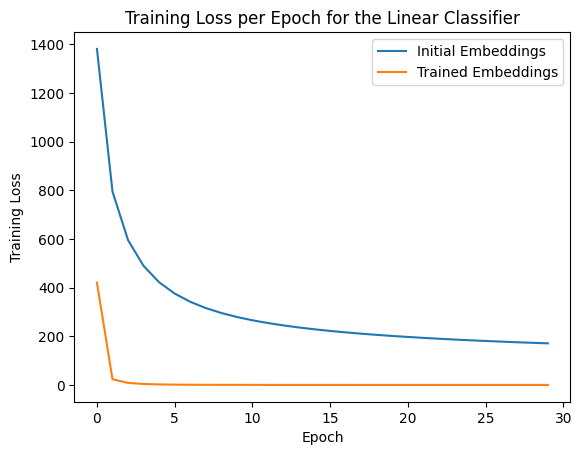

In [318]:
plt.plot(training_losses_linear_classifier, label='Initial Embeddings')
plt.plot(training_losses_linear_classifier_new, label='Trained Embeddings')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for the Linear Classifier')

plt.show()

In [319]:
def calculate_percentage(arr, threshold1, threshold2):
    count = sum(1 for num in arr if threshold1 < num < threshold2)
    percentage = (count / len(arr)) * 100
    return f"{int(percentage)}%"

In [320]:
def retrieval(text_norm, img_norm):
    score = text_norm.dot(img_norm.T)
    score_tensor = torch.tensor(score, dtype=torch.float32)
    score_softmaxed = torch.nn.functional.softmax(score_tensor, dim=-1).numpy() # apply on the last dimension/row-wise
    best = score_softmaxed.argsort()[-100:][::-1]
    return best 

In [321]:
text_image = []
best1 = retrieval(text_embeddings_trained_norm[0], image_embeddings_trained_norm)

In [322]:
initial_text_image = []
initial1 = retrieval(text_embeddings_initial_norm[0], image_embeddings_initial_norm)

In [323]:
percentage1 = calculate_percentage(best1, 0, 10407)
print(percentage1)
text_image.append(percentage1)

100%


In [324]:
initial_percentage1 = calculate_percentage(initial1, 0, 10407)
print(initial_percentage1)
initial_text_image.append(initial_percentage1)

0%


In [325]:
best2 = retrieval(text_embeddings_trained_norm[10408], image_embeddings_trained_norm)

In [326]:
initial2 = retrieval(text_embeddings_initial_norm[10408], image_embeddings_initial_norm)

In [327]:
percentage2 = calculate_percentage(best2, 10407, 20973)
print(percentage2)
text_image.append(percentage2)

100%


In [328]:
initial_percentage2 = calculate_percentage(initial2, 0, 10407)
print(initial_percentage2)
initial_text_image.append(initial_percentage2)

0%


In [329]:
best3 = retrieval(text_embeddings_trained_norm[20974], image_embeddings_trained_norm)

In [330]:
initial3 = retrieval(text_embeddings_initial_norm[20974], image_embeddings_initial_norm)

In [331]:
percentage3 = calculate_percentage(best3, 20973, 32485)
print(percentage3)
text_image.append(percentage3)

100%


In [332]:
initial_percentage3 = calculate_percentage(initial3, 0, 10407)
print(initial_percentage3)
initial_text_image.append(initial_percentage3)

0%


In [333]:
best4 = retrieval(text_embeddings_trained_norm[32486], image_embeddings_trained_norm)

In [334]:
initial4 = retrieval(text_embeddings_initial_norm[32486], image_embeddings_initial_norm)

In [335]:
percentage4 = calculate_percentage(best4, 32485, 44042)
print(percentage4)
text_image.append(percentage4)

100%


In [336]:
initial_percentage4 = calculate_percentage(initial4, 0, 10407)
print(initial_percentage4)
initial_text_image.append(initial_percentage4)

0%


In [337]:
best5 = retrieval(text_embeddings_trained_norm[44043], image_embeddings_trained_norm)

In [338]:
percentage5 = calculate_percentage(best5, 44042, 52938)
print(percentage5)
text_image.append(percentage5)

100%


In [339]:
best6 = retrieval(text_embeddings_trained_norm[52939], image_embeddings_trained_norm)

In [340]:
percentage6 = calculate_percentage(best6, 52938, 66474)
print(percentage6)
text_image.append(percentage6)

100%


In [341]:
best7 = retrieval(text_embeddings_trained_norm[66475], image_embeddings_trained_norm)

In [342]:
percentage7 = calculate_percentage(best7, 66474, 75237)
print(percentage7)
text_image.append(percentage7)

100%


In [343]:
best8 = retrieval(text_embeddings_trained_norm[75238], image_embeddings_trained_norm)

In [344]:
percentage8 = calculate_percentage(best8, 75237, 85683)
print(percentage8)
text_image.append(percentage8)

100%


In [345]:
best9 = retrieval(text_embeddings_trained_norm[85684], image_embeddings_trained_norm)

In [346]:
percentage9 = calculate_percentage(best9, 85683, 100000)
print(percentage9)
text_image.append(percentage9)

100%


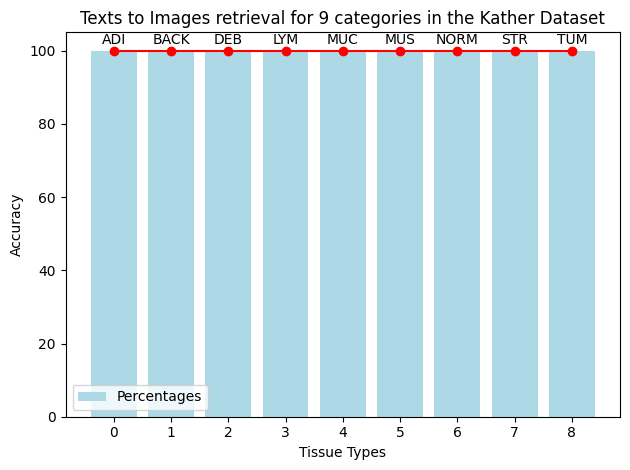

In [347]:
percentages = [int(p[:-1]) for p in text_image]

x = list(range(len(percentages)))

bars = plt.bar(x, percentages, color='lightblue', label='Percentages')
labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

for bar, label in zip(bars, labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, label, ha='center', va='bottom')

plt.plot(x, percentages, color='red', marker='o', linestyle='-', linewidth=1.5, markersize=6)

plt.xticks(x)
plt.xlabel('Tissue Types')
plt.ylabel('Accuracy')
plt.title('Texts to Images retrieval for 9 categories in the Kather Dataset')
plt.legend()

plt.tight_layout()
plt.show()

In [348]:
image_image = []
best11 = retrieval(text_embeddings_trained_norm[0], image_embeddings_trained_norm)

In [349]:
percentage11 = calculate_percentage(best11, 0, 10407)
print(percentage11)
image_image.append(percentage11)

100%


In [350]:
best12 = retrieval(text_embeddings_trained_norm[10408], image_embeddings_trained_norm)

In [351]:
percentage12 = calculate_percentage(best12, 10407, 20973)
print(percentage12)
image_image.append(percentage12)

100%


In [352]:
best13 = retrieval(text_embeddings_trained_norm[20974], image_embeddings_trained_norm)

In [353]:
percentage13 = calculate_percentage(best13, 20973, 32485)
print(percentage13)
image_image.append(percentage13)

100%


In [354]:
best14 = retrieval(text_embeddings_trained_norm[32486], image_embeddings_trained_norm)

In [355]:
percentage14 = calculate_percentage(best14, 32485, 44042)
print(percentage14)
image_image.append(percentage14)

100%


In [356]:
best15 = retrieval(text_embeddings_trained_norm[44043], image_embeddings_trained_norm)

In [357]:
percentage15 = calculate_percentage(best15, 44042, 52938)
print(percentage15)
image_image.append(percentage15)

100%


In [358]:
best16 = retrieval(text_embeddings_trained_norm[52939], image_embeddings_trained_norm)

In [359]:
percentage16 = calculate_percentage(best16, 52938, 66474)
print(percentage16)
image_image.append(percentage16)

100%


In [360]:
best17 = retrieval(text_embeddings_trained_norm[66475], image_embeddings_trained_norm)

In [361]:
percentage17 = calculate_percentage(best17, 66474, 75237)
print(percentage17)
image_image.append(percentage17)

100%


In [362]:
best18 = retrieval(text_embeddings_trained_norm[75238], image_embeddings_trained_norm)

In [363]:
percentage18 = calculate_percentage(best18, 75237, 85683)
print(percentage18)
image_image.append(percentage18)

100%


In [364]:
best19 = retrieval(text_embeddings_trained_norm[85684], image_embeddings_trained_norm)

In [365]:
percentage19 = calculate_percentage(best19, 85683, 100000)
print(percentage19)
image_image.append(percentage19)

100%


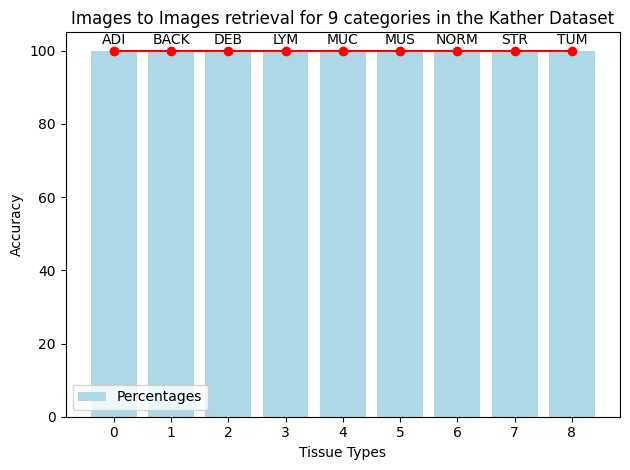

In [366]:
percentages = [int(p[:-1]) for p in image_image]

x = list(range(len(percentages)))

bars = plt.bar(x, percentages, color='lightblue', label='Percentages')
labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

for bar, label in zip(bars, labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, label, ha='center', va='bottom')

plt.plot(x, percentages, color='red', marker='o', linestyle='-', linewidth=1.5, markersize=6)

plt.xticks(x)
plt.xlabel('Tissue Types')
plt.ylabel('Accuracy')
plt.title('Images to Images retrieval for 9 categories in the Kather Dataset')
plt.legend()

plt.tight_layout()
plt.show()